
<br>
Reference: 1 Monitor ReWiS Code by Niloofar Bahadori<br>
ReWiS:<br>
One Access Point Tx with 4 Antennas, One Station Rx with 3 Antennas. 12 links, 224 x 224 images only Abs (no phase)
Single model for HAR few-shot classification (no 3 models as in majority vote)

Training:<br>
    1) Read csi_data, 2) Train the CNN embedding to find the prototypes 3) ProtoNet and Few-shot<br>
Testing:<br>
    1) Read csi_data, 2) Utilize the trained embeddings, and 3) ProtoNet for predition<br>

Few-shot learning for classifying human activities for the case of one monitor.<br>
This code does not require embedding training as the embedding is already trained.<br>
To train a model, load any dataset start with m1c1_xxx or m1c4_xxx. <br>
The code trains the model with the data collected from environment A1 and can be tested on either A2 or A3.<br>


 7 Jul 2022 AB ITIV KIT/KARLSRUHE/de - KIT/GDH ESP32 S261 Cycle=750ms dataset
23 Oct 2024 AB LARA/UnB/br - sala estudos/sala reuniões ESP32 S241 Cycle=400ms dataset

In [1]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import os
import matplotlib.pyplot as plt
import itertools
import csv
import os
import pandas
import numpy as np
import math
import cmath
import glob
import torch

from   torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from   torch.optim import Adam, SGD
from   torch.autograd import Variable

#from   tqdm import tqdm
from   scipy.io import loadmat
from   sklearn.model_selection import train_test_split
from   sklearn.metrics import accuracy_score
from   sklearn.metrics import confusion_matrix
from   scipy import signal
from   sklearn.decomposition import PCA
from   scipy.signal import butter,filtfilt
from   PIL import Image


from scipy.io import loadmat
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import trange   #tqdm.notebook.trange
#import tqdm 
from sklearn.model_selection import train_test_split
import gc


In [2]:
import multiprocessing as mp

if __name__ == "__main__":
    p = mp.get_context("spawn").Pool(16)
    print('p = ', p)
    # Exemplo de uso
    # results = p.map(worker_function, list_of_inputs)
    mp.set_start_method('spawn', force=True)
    print(mp.get_start_method())

p =  <multiprocessing.pool.Pool state=RUN pool_size=16>
spawn


In [3]:
import platform
import torch

# Verificar a versão do sistema operacional
print("Sistema operacional:", platform.system(), platform.release())

# Verificar se CUDA está disponível
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('device =', device)

Sistema operacional: Windows 10
device = cpu



<br>
 Load the dataset's folder:either m3c1_xxx or m3c4_xxx ###<br>


In [4]:
###########################
# Directories 
###########################
data_folder='data'
train_env = ''
test_env = '4'

train_folder_name = '../fewShot_UnB/' + data_folder + train_env
test_folder_name = '../fewShot_UnB/' + data_folder + test_env
model_out_name = '../fewShot_UnB/models/model_' + test_env + '.pt'
result_out_name = '../fewShot_UnB/results/result_A1' + test_env +'_' + data_folder + '.pt'

print("train_folder = ", train_folder_name,"; test_folder = ", test_folder_name)
print("model_folder = ", model_out_name,"; result_out_name = ", result_out_name)

train_folder =  ../fewShot_UnB/data ; test_folder =  ../fewShot_UnB/data4
model_folder =  ../fewShot_UnB/models/model_4.pt ; result_out_name =  ../fewShot_UnB/results/result_A14_data.pt


In [5]:
###########################
# LP Noise Reduction Filter 
###########################

T = 1.0         # Sample Period
fs = 10.0       # sample rate, Hz
cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y   

In [6]:
####################################
# Default meta-parameters for readCSI_KIT 
####################################

NS     = 4       # Number of Sensors 261 configuration 4.feb.23 GDH
# N10s   = 52    # 10s / 0,4s/BC * 4 linCSV/BC = 100 linCSIPerFrame (25 x 416) images ("Should be")
# B10s   = 13    # Broadcast available CSI in a 10s image (images are Amp/Phase: 2*B10s x 416)
n_way = 4        # 4 activity classes
oAbs   = False   # only Absolute values (no Phase)

# Without insertions 400ms give 26x26 images
# BUT!! with about 50% of BC fill 26x26 images SO: B10s = 15 uses some of the spare CSI lines 

# META-PARAMETERS
B10s   = 14     # [10:15] Broadcast available CSI in a 10s image (images are Amp/Phase: 2*B10s x 416)
N10s   = NS*B10s # 52    # 10s / 0,4s/BC * 4 linCSV/BC = 100 linCSIPerFrame (25 x 416) images ("Should be")
wPCA   = True  # with PCA data reduction 416 -> 26
wFilter= True  # median Outlyer and 3rd O. Butterworth noise reduciton filter
phaseSanit = True

n_support = 4   
n_query = 3

trainD = True   # train Data / test Data
NTrain=16      # Number of Training Files (will be divided in 60% train and 40% test for the CNN base model)
NTest=6        # Number of Test (fewShot) Files
        

showIm = False   
wEmptyFrames = False
pltCSItiming = False

CNN_Leandro = False # only train CNN (prototypes) no FewShot

meta={'NS':NS,'N10s':N10s,'wPCA':wPCA,'wFilter':wFilter,'oAbs':oAbs,'NTrain':NTrain,'NTest':NTest,'n_way':n_way,'n_support':n_support,'n_query':n_query}

useBest = False
# Load best ANN fromm models directory - 
# If a model doesn't exist. FIRST must run useBest = False (Slower train all)
# If a model exists - can Run useBest=False to enhance PROTOTYPES
# Or FAST                     useBest=True to enhance only FewShot full connected layer


In [7]:
####################################################
#   read_csiKIT - BUILD ML data from .csv files
# trainD: True (training data), False (test data)
# wPCA = True  -> with PCA -> abPCA(26,26)
#        False -> abPCA(26,416), for img visualization
# showIm = True -> show (imgI, imR, ab, abPCA)  
# Niter = number of .csv files readed (max. 9)  
# wFilter = median (for outlyers) and LP (for noise)
# oAbs = only Abs (no Phase) - (B10sx26) Images   
# 
# trainx - CSI frames 
# trainy - frame labels 
# imgI, imgR - Img and Real CSI matrices (N10sx264)
# ab, abPCA  - Abs/Phase (26x416), PCA compr.(26x26)
####################################################

def read_csiKIT (trainD, wPCA, showIm, Niter, wFilter, oAbs):

    trainy=[]
    trainx=[]
    emptyTime=[] #np.array([])
  
  
    iNiter = 0           
    if trainD==True: NFrames=23    # 5 Train experiments with 23 frames each                 
    else: NFrames=23               # 2 Test  experiment  with 23 frames 
    
    for ex in range(iNiter,Niter):
        
        # considering 4 sensors in S241. 
        if NS == 4:
            if trainD:                 # TRAIN data from "Sala de Estudos LARA" - Arq. por ordem de tamanho
                if ex==0: file_in = 'cEu_rot6_06022025.csv'
                if ex==1: file_in = 'cEu_rot1_06022025.csv'
                if ex==2: file_in = 'cEu_rot4_06022025.csv'  
                

                if ex==3: file_in = 'cEu_rot3_27012025.csv'
                if ex==4: file_in = 'cEu_rot5_27012025.csv'
                if ex==5: file_in = 'cEu_rot5_27012025.csv'
                if ex==6: file_in = 'cEu_rot4_22012025.csv'
                if ex==7: file_in = 'cEu_rot7_01022025.csv'
                if ex==8: file_in = 'cEu_rot2_27012025.csv' 
                if ex==9: file_in = 'cEu_rot4_27012025.csv'
                if ex==10: file_in = 'cEu_rot2_22012025.csv'
                if ex==11: file_in = 'cEu_rot5_01022025.csv' 
                if ex==12: file_in = 'cEu_rot3_22012025.csv'
                if ex==13: file_in = 'cEu_rot8_01022025.csv' 
                if ex==14: file_in = 'cEu_rot1_22012025.csv'
                if ex==15: file_in = 'cEu_rot6_27012025.csv'
                if ex==16: file_in = 'cEu_rot6_01022025.csv' 
                               
            else:    # captured at the same day, same conditions!
                # if ex==0: file_in = 'cEu_rot5_06022025.csv'
                # if ex==1: file_in = 'cEu_rot2_06022025.csv'
                # if ex==2: file_in = 'cEu_rot3_06022025.csv'
                                               
                if ex==0: file_in = 'crot6.csv'   
                if ex==1: file_in = 'crot1.csv'
                if ex==2: file_in = 'crot2.csv'
                if ex==3: file_in = 'crot3.csv'
                if ex==4: file_in = 'crot4.csv'   
                if ex==5: file_in = 'crot5.csv'   
     
                
        file_in = 'data4/f'+file_in   # 'f' - fixed CSI files by inserting lines to match sequence pattern
        
        if oAbs: pca = PCA(n_components = B10s)   # only Abs
        else:    pca = PCA(n_components = 2*B10s)   # Abs & Phase
    
        t = []
        y = []
        yv= []
        ya= []
        carrier = []
        bords=[]
        bordC=[]
        nImg=1

        with open(file_in,'r') as csvfile:
            lines = csv.reader(csvfile, delimiter=',')
            for row in lines:
                t.append(float(row[13]))
                y.append(row[16])
                
        # Subtrai offset de t[0] -> polarização do tempo, desloca todos os valores de CSI
        #for indi in range(len(t)):
        #    t[indi]-=t[0]        
        
        diff=0      
        #--------------------- 
        if pltCSItiming: 
            if ex==0:
                print('experiment ex:',ex,'len(y)',len(y),'NS',NS,'N10s',N10s,'t[ini],t[ini+52],diff,ini,int((ini+1)/52),pas,pas-ini')
                plt.figure(figsize=(10, 5))
        
        if showIm:
            if ex==0:
                fig, axs = plt.subplots(round(NFrames/6),6)   # 
                fig.suptitle(file_in+'CSI Amplitude (4 x 416) :> 416 subcarriers = 4 sensors*(108 -4 pilots)')
                plt.axis('off')
                fig.set_figwidth(10)
                fig.set_figheight(10)

                fg, ax = plt.subplots(round(NFrames/6),6)
                fg.suptitle('CSI PCA (40 x 40) -> PCA 40 components')
                plt.axis('off')
                fg.set_figwidth(10)
                fg.set_figheight(10)

        ######################################
        # find 10 sec borders
        ######################################
        nearest = 100
        for idx, val in enumerate(t):
            searchV = nImg*10000.
            if searchV -val < nearest:      # approximating the border
                nearest = searchV - val 
                bord=[idx, val]
            if nearest <= 0:                # getting away from th border
                bords.append(bord)          # Register the border (last nearest)
                nImg+=1
                nearest = t[idx+2]                
        bords=np.array(bords)
        #print('bords',bords)
        
        ######################################
        # find 400 msec borders (BroadCast CYCLE)
        ######################################
        nearestC = 100    
        nImg = 1
        for idxx, valx in enumerate(t):
            searchV = nImg*1000.
            if searchV -valx < nearestC:      # approximating the border
                nearestC = searchV - valx 
                bordA=[idxx, valx]
            if nearestC <= 0:                # getting away from th border
                bordC.append(bordA)          # Register the border (last nearest)
                nImg+=1
                nearestC = t[idxx+0]                
        bordC=np.array(bordC)
     
        #-----------------
        # if pltCSItiming:
        #     if ex==0:
        #         print('bordC',len(bordC)) #,bordC[1,1]-bordC[0,1],bordC[2,1]-bordC[1,1])
        #         for ii in range(30):
        #             print(bordC[ii,1]*0.001,(bordC[ii+1,1]-bordC[ii,1])*0.001)
        #             print(bordC)
         
        #-------------------- 
        # diff=np.array([40])
        # for ii in range(0,39):
        #    diff[ii]=bordC[ii+1,1]-bordC[ii,1]
        # print('diff',diff*0.001) 
        # print('t',np.array(t[0:40]))  
        #print('bordC',bordC[0:40,0],bordC[0:40,1]*0.001,(bordC[0:40,1]-bordC[0,1])*0.001)
        
        ######################################
        # join CSI lines from the last border, until 10 seconds frame is complete
        for k in range (NFrames):            
            CSi = []
            CSr = []
            var = []
            
            if k == 0: ini = 0
            else : ini = int(bords[k-1,0])
            pas = int(bords[k,0])
            
            diff = int(t[pas] -int(t[ini+52]))
            ######################################
            #while t(n) in next 10s window
            #-----------------------------
            #print('t[ini], t[ini+52],ini,(ini+1)/52,pas,pas-ini',int(t[ini]),int(t[ini+52]),diff,ini,int((ini+1)/52),pas,pas-ini)
            
            #--------------
            if pltCSItiming:
                if ex==0:
                    ttt=np.array(t)
                    xtt=[]
                    xtt=range(ini,ini+52)
                    if k<2:
                        plt.plot(xtt,ttt[ini:ini+52]*0.001,'*')


            # take the first 52 CSI lines
            for j in range (ini, ini+N10s, NS):         # One 10 seconds Frame
                cvv=[]
                for i in range(NS):            
                    cvv.append([float(item) for item in y[i+j][1:-1].split(',')]) 
            
            # tAnt = t[ini]
            # tTaken = []
            
            # j=ini
            # while j < ini+pas & len(tTaken) < N10s:    # Fill a 10 seconds Frame, skipping old data
             
            #     cvv=[]
                
            #     #while t[j] < tAnt: # move on, if first sensor is older than tAnt
            #     #    j+=NS
            #     tTaken.append(j)
            #     print('tTaken',tTaken)
                
            #     # vetTaken=[]
            #     # aux=ini
            #     # while aux < j:
            #     #     vetTaken.append(t[tTaken[aux]])
            #     #     aux+=NS
            #     # print('t[tTaken]',vetTaken)
                
            #    for i in range(NS):            
            #        cvv.append([float(item) for item in y[i+j][1:-1].split(',')]) 


                cv=np.array(cvv)
                cv=cv.flatten()            # 1080 CSI values => 1 line of CSI image

                ci=cv[0:len(cv):2]         # Frame Size = [N10s/Ns,(216/2 Im,Re || Amp,Pha)*NS]
                cr=cv[1:len(cv):2]

                if NS ==2:
                    idxRm = [26, 53, 80, 107, 134, 161, 188, 215]     # Remove 8 beacon zeroes 
                else: # NS ==4:
                    idxRm = [ 26,  53,  80, 107, 134, 161, 188, 215, 242, 269, 296, 323, 350, 377, 404, 431]
    
                #else:  # NS == 6
                #    idxRm = [ 26,  53,  80, 107, 134, 161, 188, 215, 242, 269, 296, 323, 350, 377, 404, 431, 458, 485, 512, 539, 566, 593, 620, 647]
     
                for m in sorted (idxRm, reverse=True):
                    ci=np.delete(ci,m)
                    cr=np.delete(cr,m)
                
                CSi.append(ci)
                CSr.append(cr)
                
                # tAnt = t[j]
                # #if j==N10s:     # 52, 13 x 2 = 26 lines of a image fullfilled 
                # #    break
                # j=+NS
                
            emptyTime=np.append(emptyTime,t[pas]-t[j])
            
            imgI = np.array(CSi,dtype=float)
            imgR = np.array(CSr,dtype=float)

            #aa=np.array(imgI)
            #ap=np.array(imgR)
            li,co = imgI.shape
            
            if oAbs: rang=li
            else: rang=2*li
            
            if oAbs:
                ab=np.zeros((li,co)) # both: Amp & Phase
                for i in range(li):
                    for c in range(co):
                        ab[i][c]=abs(complex(imgI[i,c],imgR[i,c]))
            else:
                ab=np.zeros((2*li,co)) # both: Amp & Phase
                for i in range(li):
                    for c in range(co):
                        ab[i][c]=abs(complex(imgI[i,c],imgR[i,c]))
                        ab[i+li][c]=cmath.phase(complex(imgI[i,c],imgR[i,c]))
                    
            
    ######################################
    # median Filter - catch outlyers in each line
    ######################################                   
            #print('wFilter',wFilter)
            if wFilter:
                for i in range(rang):
                    ab[i] = signal.medfilt(ab[i])    
                
    ######################################
    # Sanitize Phase 
    ######################################                   
            if oAbs == False:
                if phaseSanit:
                    for i in range(li-1):   # Use difference of the same carrier frequency
                        for c in range(co):
                            delta = ab[i+li+1][c]-ab[i+li][c]
                            if delta > 3.1415926:
                                ab[i+li+1][c]-=2*3.1415926
                            if delta < -3.1415926:
                                ab[i+li+1][c]+=2*3.1415926
                    
                # 11Fev2025            
                # if np.mean(ab[li:2*li][:]) > 0: #Ensure causality, negative phase!
                #     ab[li:2*li][:]-=2*3.1415926
    ######################################
    # Low Pass - reduce noise 
    ######################################                   
            if wFilter:
                for i in range(rang):
                    ab[i] = butter_lowpass_filter(ab[i],cutoff,fs,3)      

    # 23.Jan.2023
    #    sit stand walk empty empty walk stand sit stand walk empty empty walk stand sit
    # k: 0   3     6    9     12    15   18    21  24    27   30    33    36   39    42
            
    # 17 Set 2024 LARA Leandro & Andressa
    #    empty  walk  sit  stand walk 
    # k: 0   6     9   15     21   24

            if k in range(0,6): ttxt='empty'
            if k in range(6,9) or k in range (21,24): ttxt='walk'
            if k in range(9,15): ttxt='sit'
            if k in range(15,21): ttxt='stand'

            if showIm:
                if ex==0:
                    axs[k//6,k%6].imshow(ab, interpolation='nearest',aspect='auto')   
                    axs[k//6,k%6].axis('off')
                    axs[k//6,k%6].title.set_text(ttxt)

            if wPCA:
                abPCA = pca.fit_transform(ab)
            else:
                abPCA = ab
            
            if showIm:
                if ex==0:
                    ax[k//6,k%6].imshow(abPCA, interpolation='nearest',aspect='auto')   
                    ax[k//6,k%6].axis('off')
                    ax[k//6,k%6].title.set_text(ttxt)
                    

            trainy.append(ttxt)
            trainx.append(abPCA)    
                  
        tt=np.array(t)

        #-----------------------
        if pltCSItiming:
            if ex==0:
                plt.plot(tt[0:52*3]*0.001,label='t')
                for indi in range(3):
                    plt.plot([0, 52*3],[indi*10, indi*10],'--')
                plt.title('t in '+file_in)
                plt.legend()
                plt.xlabel('CSI line in csv File')
                plt.ylabel('s')
                plt.show()
        
    
        emptyTime=emptyTime[:-1]
    
    trainy = np.array(trainy)
    if wEmptyFrames:
        plt.figure()
        plt.plot(emptyTime[:-1]/1000,label='et')
        plt.title('Empty Time in Frames of '+file_in)
        plt.legend()
        plt.xlabel('Frames')
        plt.ylabel('s')
        plt.show()
        
    return trainx, trainy, imgI, imgR, ab, abPCA

In [8]:
val_x, val_y, imgI, imgR, ab, abPCA = read_csiKIT(trainD=False,wPCA=wPCA, showIm=showIm,Niter=NTest,wFilter=wFilter,oAbs=oAbs)


In [9]:
# print('ab',ab.shape)
# if oAbs:
#     pca = PCA(n_components = B10s)   # only Abs
# else: 
#     pca = PCA(n_components = 2*B10s)   # only Abs
# abPCA = pca.fit_transform(ab)
# print('abPCA',abPCA.shape)


%

In [10]:
def extract_sample(n_way, n_support, n_query, datax, datay, test = False):
  """
  Picks random sample of size n_support+n_querry, for n_way classes
  Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of CSI dataframes
      datay (np.array): dataset of labels
  Returns:
      (dict) of:
        (torch.Tensor): sample of CSI dataframes. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
  """
  sample = []
  if test:
  #    K = np.array(['empty', 'jump', 'stand', 'walk'])  # Bahadori
  #    K = np.array(['empty', 'sit', 'stand', 'walk'])   # AB - Karlsruhe 2023
      K = np.array(['empty', 'walk', 'sit', 'stand'])   # 4/2/2025
  else:
      K = np.random.choice(np.unique(datay), n_way, replace=False)
  #print('K',K)
  for cls in K:
    datax_cls = datax[datay == cls]
    
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
    
  sample = np.array(sample)
  #print('sample',sample.shape)

  ######
  #sample = np.vstack(sample).astype(np.float32)
#  sample = np.vstack(sample).astype(np.float)
  #sample = torch.from_numpy(sample)          # 17 fev 2023
  sample = torch.from_numpy(sample).float()    # 10 fev 2023
  # sample = torch.from_numpy(sample).float()    # 10 fev 2023
  # sample = sample.permute(0,1,4,2,3)
  #sample = np.expand_dims(sample, axis= 0)
  return({
      'csi_mats': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })

ample_example = extract_sample(2, 8, 5, trainx, trainy)<br>
%

In [11]:
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()
  def forward(self, x):
    return x.view(x.size(0), -1)

def euclidean_dist(x, y):
  """
  Computes euclidean distance btw x and y
  Args:
      x (torch.Tensor): shape (n, d). n usually n_way*n_query
      y (torch.Tensor): shape (m, d). m usually n_way
  Returns:
      torch.Tensor: shape(n, m). For each query, the distances to each centroid
  """
  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    Args:
        encoder : CNN encoding the CSI dataframes in sample
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
    """
    super(ProtoNet, self).__init__()
   # self.encoder = encoder.cuda(0)
    self.encoder = encoder.to(device)
  def set_forward_loss(self, sample):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
   # sample_images = sample['csi_mats'].cuda(0)
    sample_images = sample['csi_mats'].to(device)
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']
    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]
   
    #target indices are 0 ... n_way-1
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
   # target_inds = target_inds.cuda(0)
    target_inds = target_inds.to(device)
 
   
   
    #encode CSI dataframes of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
   
    z = self.encoder.forward(x)
    z_dim = z.size(-1) #usually 64
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
    z_query = z[n_way*n_support:]

    #compute distances
    dists = euclidean_dist(z_query, z_proto)
    
    #compute probabilities
    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
   
    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
   
    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        # ,'target':target
        }  

In [12]:
def load_protonet_conv(**kwargs):
  """
  Loads the prototypical network model
  Arg:
      x_dim (tuple): dimension of input CSI dataframes
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded CSI dataframes
  Returns:
      Model (Class ProtoNet)
  """
  x_dim = kwargs['x_dim']
  hid_dim = kwargs['hid_dim']
  z_dim = kwargs['z_dim']

  print("x_dim", x_dim)
  print("hid_dim", hid_dim)
  print("z_dim", z_dim)

  def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )
  if CNN_Leandro:
    encoder = nn.Sequential(
      conv_block(x_dim[0], hid_dim),
      conv_block(hid_dim, hid_dim),
      conv_block(hid_dim, z_dim),
      Flatten()
      )
  else:  
    encoder = nn.Sequential(
      conv_block(x_dim[0], hid_dim),
      conv_block(hid_dim, hid_dim),
      conv_block(hid_dim, hid_dim),
      conv_block(hid_dim, z_dim),
      Flatten()
      )

  return ProtoNet(encoder)

In [13]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
  """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): CSI dataframes of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
  #divide the learning rate by 2 at each epoch, as suggested in paper
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
  epoch = 0 #epochs done so far
  stop = False #status to know when to stop

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0

    for episode in trange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
      sample = extract_sample(n_way, n_support, n_query, train_x, train_y, test = False)
      #print(sample)
      
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample)
      running_loss += output['loss']
      running_acc += output['acc']
      loss.backward()
      optimizer.step()
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
    
    epoch += 1
    scheduler.step()

In [14]:
# args.device = torch.device('cuda:' + str(args.gpu_id))

#model = load_protonet_conv(
#    x_dim=(1,512,256),
#    hid_dim=64,
#    z_dim=64,
#    )


#model = load_protonet_conv(
#    x_dim=(1,242,242),
#    x_dim=(1,208,208),
#    x_dim=(1,34,34),
#    x_dim=(1,32,32), # 21/10/2024
#     x_dim=(1,64,64),
#    hid_dim=32,
#    hid_dim=128,
#    z_dim=64,
#    )    

if CNN_Leandro:
    model = load_protonet_conv(
        x_dim=(1,64,64),
        hid_dim=128,
        z_dim=64,
        )    
else:
    model = load_protonet_conv(
        x_dim=(1,512,512),
        hid_dim=248,
        z_dim=64,
        )    

print(model)

x_dim (1, 512, 512)
hid_dim 248
z_dim 64
ProtoNet(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 248, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(248, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(248, 248, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(248, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(248, 248, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(248, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(

In [15]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): CSI dataframes of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  conf_mat = torch.zeros(n_way, n_way)
  running_loss = 0.0
  running_acc = 0.0
  for episode in trange(test_episode):
    sample = extract_sample(n_way, n_support, n_query, test_x, test_y, test = True)
    #print('test_episode',test_episode,'test_y: ',test_y,'sample: ',sample)
    loss, output = model.set_forward_loss(sample)
    a = output['y_hat'].cpu().int()

    #print('sample n_way,n_support,n_query',sample['n_way'], sample['n_support'],sample['n_query'])
    #print('sample CSI',sample['csi_mats'])
      # 'csi_mats': sample,
      # 'n_way': n_way,
      # 'n_support': n_support,
      # 'n_query': n_query
      # })
    #print('CNN output: ',a)

    #a = output['y_hat'].mps().int()
    for cls in range(n_way):
        conf_mat[cls,:] = conf_mat[cls,:] + torch.bincount(a[cls,:], minlength=n_way) 
    
    # To check accuracy!
    #print('torch.bincount(a[cls,:]',torch.bincount(a[cls,:]))
        
    running_loss += output['loss']
    running_acc += output['acc']
  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))
  return (conf_mat/(test_episode*n_query), avg_acc)
# %%

In [16]:
########################
# # MAIN TEST LOOP
########################
optimizer = optim.Adam(model.parameters(), lr = 0.003)


# META-PARAMETERS to test:

##############################################################
# useBest = False -> MAIN (non-linear CNN) PROTOTYPEs TRAINING 
# useBest = True -> use the best saved model(wPCA,n_querry)
##############################################################
if wPCA:      tPCA = 'wPCA'
else: tPCA = 'nPCA'
if wFilter:   tF = 'wF'
else: tF = 'nF'
if phaseSanit:   tS = 'wS'
else: tS = 'nS'

nameFile = 'B10s'+str(B10s)+'_'+tF+'_'+tS+'_'+tPCA+'_n'+str(n_support)+'sup'+'_n'+str(n_query)+'qry'+ '.pt'
result_out_name = 'results/result_' + nameFile
meta_out_name = 'results/meta_' + nameFile
model_out_name = 'models/model_' + nameFile

if useBest:  
    result = {'CF_val':CF_val, 'acc_val':acc_val}
    model=torch.load(model_out_name, weights_only=False)
    result=torch.load(result_out_name)
    meta=torch.load(meta_out_name)
    
    NS=meta['NS']
    N10s=meta['N10s']
    wPCA=meta['wPCA']
    wFilter=meta['wFilter']
    oAbs=meta['oAbs']
    NTrain=meta['NTrain']
    NTest=meta['NTest']
    n_way=meta['n_way']
    n_support=meta['n_support']
    n_query=meta['n_query']
else:
    #################################
    # Load TRAIN Data -> study Room
    # # ===================================================>  TRAIN
    trainx, trainy, imgI, imgR, ab, abPCA = read_csiKIT(trainD=True,wPCA=wPCA, showIm=showIm,Niter=NTrain,wFilter=wFilter,oAbs=oAbs)

    trainx=np.array(trainx)
    # print(trainx[0:4,:,0:3])

    trainx = np.expand_dims(trainx, axis=1)
    print(trainx.shape)

    ############
    # Split - Train + Test 
    train_x, test_x, train_y, test_y = train_test_split(trainx, trainy, test_size = 0.30, random_state=10, shuffle=True)

    train_y=np.array(train_y)
    test_y=np.array(test_y)
    print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

    max_epoch = 2
    epoch_size = 1000
    test_episode = 100

    trainy=np.array(trainy)

    print('train size, trainx:',trainx.shape, 'trainy:',trainy.shape)
    print('n_way,n_support,n_query,test_episode',n_way,n_support,n_query,test_episode)
    
    print('\nTRAIN prototypes 80\% trainD and test it with 20\% of trainD (NTrain=16, ex Files)')


    #########################################################
    # Train embedding to get prototypes with train_x, train_y
    ########################################################
    train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)
    
    # Test with a different set test_x, testy
    CF_test, acc_test=test(model, test_x, test_y, n_way, n_support, n_query, test_episode)
    
    
###########################################
# fewShot Transfer Learning -> Study Room
###########################################        trainD=False => TEST!
val_x, val_y, imgI, imgR, ab, abPCA = read_csiKIT(trainD=True,wPCA=wPCA, showIm=showIm,Niter=NTest,wFilter=wFilter,oAbs=oAbs)

val_x = np.array(val_x)
val_x = np.expand_dims(val_x, axis=1)
val_y = np.array(val_y)

CF_valFS, acc_valFS = test(model, val_x, val_y, n_way, n_support, n_query, test_episode)

#print('validation size, val_x',val_x.shape,'val_y',val_y.shape)

print('\nFewShot Learned CNN Transfer to Lara''s Meeting Room - trainD=False (Ntest=6, ex Files)\n')
print('CF_test ProtoType',acc_test,' acc_valFS: ',acc_valFS)



###########################################
# fewShot Transfer Learning -> Meeting Room
###########################################        trainD=False => TEST!
val_x, val_y, imgI, imgR, ab, abPCA = read_csiKIT(trainD=False,wPCA=wPCA, showIm=showIm,Niter=NTest,wFilter=wFilter,oAbs=oAbs)

val_x = np.array(val_x)
val_x = np.expand_dims(val_x, axis=1)
val_y = np.array(val_y)

test_episode = 100
CF_val, acc_val = test(model, val_x, val_y, n_way, n_support, n_query, test_episode)

#print('validation size, val_x',val_x.shape,'val_y',val_y.shape)
#print("CF_test",CF_test, ' acc_test: ',acc_test,"CF_val",CF_val, ' acc_val: ',acc_val)
print('test',acc_test,' acc_val: ',acc_val)


result = {'CF_val':CF_valFS, 'acc_val':acc_valFS}
print('\n>>> Este treino acc_val('+model_out_name[-15:]+'): ',round(result['acc_val'],3))
#print(meta)
print(' ')

# Save anyway if it is the first training for this model+meta-parameters
if not os.path.isfile(model_out_name):
    
    torch.save(model, model_out_name)
    # torch.save({
    #     'model_state_dict': model.state_dict(),
    #     'optimizer_state_dict': optimizer.state_dict(),
    #     }, model_out_name)
    torch.save(result, result_out_name)
    torch.save(meta, meta_out_name)

result = torch.load(result_out_name)

if result['acc_val'] > acc_valFS:
    print('>>> Modelo salvo é ainda melhor - será mantido!',round(result['acc_val'],3),'\n')
else:
    result = {'CF_val':CF_valFS, 'acc_val':acc_valFS}
    metaPar = {}

    torch.save(model, model_out_name)
    torch.save(result, result_out_name)
    torch.save(meta, meta_out_name)
    print('>>> Salvando este modelo - é o melhor! ' ,round(result['acc_val'],3),'\n')                                                                                

dictRes = {'acc':[],'model':[]}

bestResults = glob.glob('results/result*.pt')
for i in range(len(bestResults)):
    result=torch.load(bestResults[i])
    ttx = str(bestResults[i])
    ttx=ttx[15:-3]
    dictRes['model'].append(ttx)
    dictRes['acc'].append(round(float(result['acc_val']),3))
    
# Pair and sort by accuracy in descending order
paired = list(zip(dictRes['acc'], dictRes['model']))
sorted_pairs = sorted(paired, key=lambda x: x[0], reverse=True)

for acc, model in sorted_pairs:
    print(f"acc({model}):\t {acc:.3f}")


(368, 1, 28, 28)
(257, 1, 28, 28) (257,) (111, 1, 28, 28) (111,)
train size, trainx: (368, 1, 28, 28) trainy: (368,)
n_way,n_support,n_query,test_episode 4 4 3 100

TRAIN prototypes 80\% trainD and test it with 20\% of trainD (NTrain=16, ex Files)


Epoch 1 train:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1 -- Loss: 0.5786 Acc: 0.7482


Epoch 2 train:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2 -- Loss: 0.0023 Acc: 0.9994


  0%|          | 0/100 [00:00<?, ?it/s]

Test results -- Loss: 2.6733 Acc: 0.6350


  0%|          | 0/100 [00:00<?, ?it/s]

Test results -- Loss: 0.8860 Acc: 0.9283

FewShot Learned CNN Transfer to Laras Meeting Room - trainD=False (Ntest=6, ex Files)

CF_test ProtoType 0.6349999961256981  acc_valFS:  0.9283333373069763


  0%|          | 0/100 [00:00<?, ?it/s]

Test results -- Loss: 2.6051 Acc: 0.4975
test 0.6349999961256981  acc_val:  0.49749999701976777

>>> Este treino acc_val(_n4sup_n3qry.pt):  0.928
 
>>> Salvando este modelo - é o melhor!  0.928 

acc(B10s14_wF_wS_wPCA_n4sup_n3qry):	 0.928


C:\Users\Dekomonte\AppData\Local\Temp\ipykernel_7584\4266465985.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  result = torch.load(result_out_name)
C:\Users\Dekomonte

In [17]:
import torch

# Caminho do arquivo (substitua pelo seu caminho correto)
file_path = r"C:\Users\Dekomonte\OneDrive\Documentos\DiretorioTG_atual\few-shot_ultima_versao\results\result_B10s14_wF_wS_wPCA_n4sup_n3qry.pt"

# Carregar o arquivo
data = torch.load(file_path, map_location=torch.device('cpu'))

# Exibir informações gerais
print(f"Tipo do conteúdo: {type(data)}")

# Se for um dicionário, mostrar as chaves
if isinstance(data, dict):
    print("Chaves do dicionário:", data.keys())

    # Exibir o conteúdo de cada chave (de forma resumida)
    for key, value in data.items():
        print(f"\nChave: {key}")
        print(f"Tipo: {type(value)}")
        
        # Se for um tensor do PyTorch, mostrar o shape
        if isinstance(value, torch.Tensor):
            print(f"Shape do tensor: {value.shape}")
        
        # Se for uma lista, mostrar o tamanho
        elif isinstance(value, list):
            print(f"Tamanho da lista: {len(value)}")

        # Se for um número ou string, imprimir diretamente
        else:
            print(f"Valor: {value}")



Tipo do conteúdo: <class 'dict'>
Chaves do dicionário: dict_keys(['CF_val', 'acc_val'])

Chave: CF_val
Tipo: <class 'torch.Tensor'>
Shape do tensor: torch.Size([4, 4])

Chave: acc_val
Tipo: <class 'float'>
Valor: 0.9283333373069763


C:\Users\Dekomonte\AppData\Local\Temp\ipykernel_7584\1862795259.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path, map_location=torch.device('c

In [18]:
import torch

# Caminho do arquivo
file_path = r"C:\Users\Dekomonte\OneDrive\Documentos\DiretorioTG_atual\few-shot_ultima_versao\results\result_B10s14_wF_wS_wPCA_n4sup_n3qry.pt"

# Carregar o arquivo
data = torch.load(file_path, map_location=torch.device('cpu'))

# Exibir matriz de confusão
print("Matriz de Confusão:")
print(data["CF_val"])

# Exibir acurácia
print(f"\nAcurácia: {data['acc_val']:.2%}")


Matriz de Confusão:
tensor([[0.9667, 0.0000, 0.0300, 0.0033],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.1567, 0.0000, 0.8400, 0.0033],
        [0.0267, 0.0167, 0.0500, 0.9067]])

Acurácia: 92.83%


C:\Users\Dekomonte\AppData\Local\Temp\ipykernel_7584\4293510849.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path, map_location=torch.device('c

C:\Users\Dekomonte\AppData\Local\Temp\ipykernel_7584\1396969441.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path, map_location=torch.device('

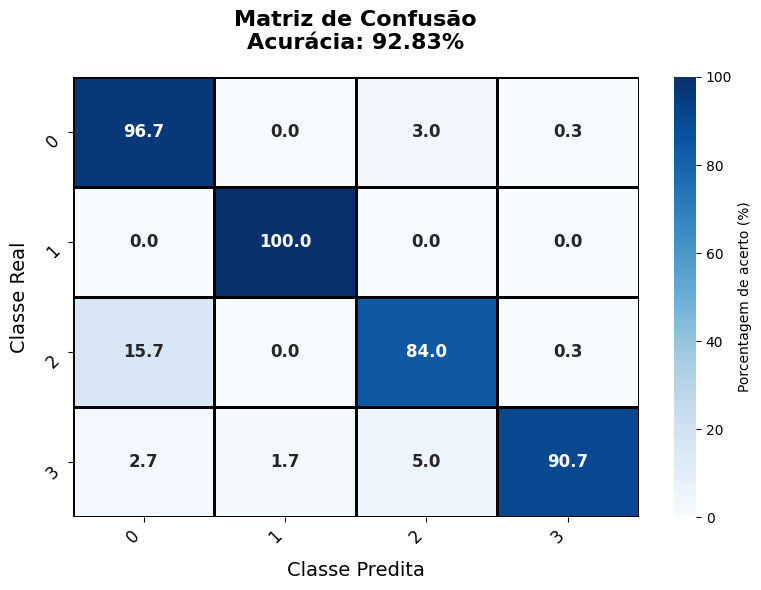

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Caminho do arquivo
file_path = r"C:\Users\Dekomonte\OneDrive\Documentos\DiretorioTG_atual\few-shot_ultima_versao\results\result_B10s14_wF_wS_wPCA_n4sup_n3qry.pt"

# Carregar os dados
data = torch.load(file_path, map_location=torch.device('cpu'))

# Obter a matriz de confusão e a acurácia
cf_matrix = data["CF_val"].numpy()  # Converter para NumPy
acc = data["acc_val"]

# Converter para porcentagem (0-100%)
cf_matrix_percentage = cf_matrix * 100

# Ajustar o tamanho da figura
plt.figure(figsize=(8, 6))

# Criar o heatmap com melhorias visuais
sns.heatmap(cf_matrix_percentage, annot=True, fmt=".1f", cmap="Blues", cbar=True, linewidths=1, linecolor='black',
            annot_kws={"size": 12, "weight": 'bold'}, cbar_kws={'label': 'Porcentagem de acerto (%)'}, 
            xticklabels=True, yticklabels=True)

# Ajustar os rótulos dos eixos
plt.xlabel("Classe Predita", fontsize=14, labelpad=10)
plt.ylabel("Classe Real", fontsize=14, labelpad=10)
plt.title(f"Matriz de Confusão\nAcurácia: {acc:.2%}", fontsize=16, fontweight='bold', pad=20)

# Ajustar a visualização para evitar sobreposição de texto
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(rotation=45, va="top", fontsize=12)

# Ajustar o layout para melhorar a apresentação
plt.tight_layout()

# Exibir o gráfico
plt.show()


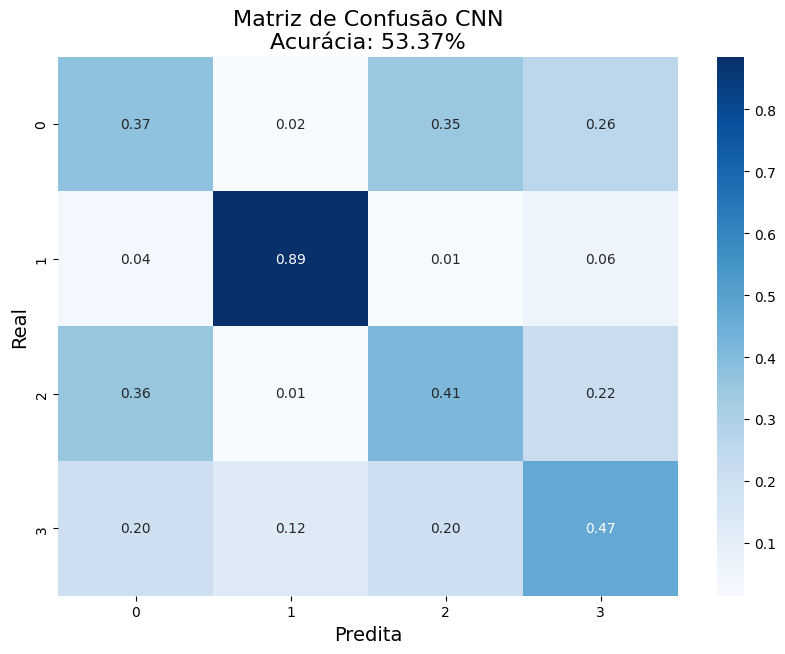

In [56]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# # Defina o caminho para o arquivo .pt
# caminho_arquivo = r'C:\Users\Dekomonte\OneDrive\Documentos\DiretorioTG_atual\RedeNeural1\results\resultado_todos_arquivos.pt'

# # Carregar o modelo
# model = torch.load(caminho_arquivo, weights_only=True)


# Supondo que resultados['CF'] é a matriz de confusão
cf_matrix = np.array([[0.3725, 0.0175, 0.3500, 0.2600],
                      [0.0375, 0.8850, 0.0150, 0.0625],
                      [0.3575, 0.0150, 0.4100, 0.2175],
                      [0.2050, 0.1250, 0.2025, 0.4675]])  # Converta para numpy se necessário

plt.figure(figsize=(10, 7))
sns.heatmap(cf_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predita',fontsize=14)
plt.ylabel('Real',fontsize=14)
plt.rcParams.update({'font.size': 10})
plt.title('Matriz de Confusão CNN\nAcurácia: 53.37%',fontsize=16)
plt.show()